In [ ]:
# Danila Valko
# July 2023

### setup

In [ ]:
%%capture
!pip install basemap
!pip install ray
!rm -rf ln-topology-analysis
!git clone https://github.com/ellariel/ln-topology-analysis

In [ ]:
cd ./ln-topology-analysis/

/content/ln-topology-analysis/ln-topology-analysis


In [ ]:
%matplotlib inline
import random, time, json, pickle, os, pandas as pd
from geopy.distance import geodesic
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np
from networkx.readwrite import json_graph
from datetime import datetime
from tqdm import tqdm, notebook
import seaborn as sns
from scipy import stats
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel
from scipy.stats import pearsonr, spearmanr
from itertools import islice
import warnings
warnings.filterwarnings("ignore")

import utils, proto

In [ ]:
def plot_ecdf(data, label='', log=False):
    data = data.copy()
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot()
    sns.ecdfplot(data=data, legend=data, log_scale=log)
    plt.xlabel(label)
    plt.ylabel("ECDF")
    plt.show()

def get_stars(p, p001='***', p01='**', p05='*', p10=''):
    if p < 0.001:
        return p001
    if p < 0.010:
        return p01
    if p < 0.050:
        return p05
    if p < 0.100:
        return p10
    return ''

def print_stat(m, l1, r1, l2, r2):
    t, p = mannwhitneyu(r1, r2)
    e = (np.mean(r1)-np.mean(r2)) * 100 / np.mean(r2)
    print(f"{f'{m}: ':<8}{l1} {np.mean(r1):.3f}({len(r1)}) <> {l2} {np.mean(r2):.3f}({len(r2)}), ε={'+' if e>0 else ''}{e:.1f}%, U={t}, p={p:.3f}{get_stars(p)}")

def _plot(data, metrics, labels=None, title=''):
  def draw(ax, keys, labels):
      for idx, k in enumerate(keys):
        if k in data:
          sns.lineplot(ax=ax, data=data, x='e', y=k, label=labels[idx], color=_plot.palette[_plot.c], errorbar='ci')
          _plot.c += 1

  _plot.palette, _plot.c = list(mcolors.TABLEAU_COLORS.values()), 0#list(mcolors.CSS4_COLORS.values())[45:]
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(221)
  draw(ax, metrics, metrics if not labels else labels)
  ax.set_ylabel('ε, %', fontsize=14)
  ax.set_xlabel('η', fontsize=13)
  ax.legend(loc='upper center')
  fig.tight_layout()
  plt.title(title)
  plt.show()

In [ ]:
base_dir = './'
snapshots_dir = os.path.join(base_dir, 'snapshots')
results_dir = os.path.join(base_dir, 'results')

In [ ]:
with open(os.path.join(snapshots_dir, 'ln-graph-prepared.pickle'), 'rb') as f:
    f = pickle.load(f)
    G = f['directed_graph']
    print(f'nodes: {len(G.nodes)} edges: {len(G.edges)}')
    T = f['transactions']#[:1000] ####
    print(f'transactions: {len(T)}')

with open(os.path.join(snapshots_dir, 'global_energy_mix.json'), 'r') as f:
    global_energy_mix = json.load(f)

nodes: 5966 edges: 59890
transactions: 10000


In [ ]:
if not os.path.exists(os.path.join(results_dir, 'metric_results.pickle')):
    %run examine.py

nodes: 5966 edges: 59890
transactions: 10000


2023-06-15 09:06:22,263	INFO worker.py:1636 -- Started a local Ray instance.
100%|██████████| 24/24 [02:18<00:00,  5.79s/it]


In [ ]:
f = os.path.join(results_dir, 'metric_results.pickle')
with open(f, 'rb') as f:
    metric_results = pickle.load(f)
    print(f'{f.name} - loaded')
    e = list(metric_results.keys())

./results/metric_results.pickle - loaded


In [ ]:
native_alg = ['LND', 'CLN', 'ECL']
t_continents = {}
t_countries = {}
t_nodes = {}
for a in native_alg:
  t_continents[a] = []
  t_countries[a] = []
  t_nodes[a] = []
  f = os.path.join(os.path.join(results_dir, a), f'{a}_results.pickle')
  if os.path.exists(f):
    with open(f, 'rb') as f:
        print(f'{f.name} - loaded')
        for t in pickle.load(f):
          if t[1]:
            t_continents[a] += t[1]['continents']
            t_countries[a] += t[1]['countries']
            t_nodes[a] += t[1]['path']

./results/LND/LND_results.pickle - loaded
./results/CLN/CLN_results.pickle - loaded
./results/ECL/ECL_results.pickle - loaded


### topology and geography analysis

In [ ]:
print(f'nodes: {len(G.nodes)} edges: {len(G.edges)}')

nodes: 5966 edges: 59890


In [ ]:
# https://arxiv.org/pdf/1901.04972.pdf

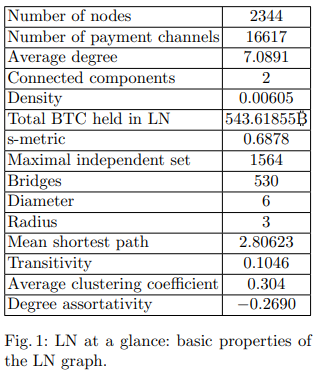

In [ ]:
random.seed(13)
np.random.seed(13)
def shortest_path_length_approximation(g, n_samples=10000):
    result = []
    for component in nx.connected_components(g):
            component_ = g.subgraph(component)
            nodes = component_.nodes()
            lengths = []
            for _ in range(n_samples):
                n1, n2 = random.choices(list(nodes), k=2)
                length = nx.shortest_path_length(component_, source=n1, target=n2)
                lengths.append(length)
            result.append(np.mean(lengths))
    return result
diameter_connected_component = [nx.approximation.diameter(G.subgraph(c)) for c in nx.connected_components(G.to_undirected())]

print(f'Number of nodes: {len(G.nodes)}')
print(f'Number of channels: {len(G.edges)}')
print(f'Average degree: {np.mean([d for _, d in G.degree])}')
print(f'Connected components: {nx.number_connected_components(G.to_undirected())}')
print(f'Density: {nx.density(G)}')
print(f'Diameter: {np.max(diameter_connected_component)}')
print(f'Bridges: {len(list(nx.bridges(G.to_undirected())))}')
print(f'Average shortest path: {np.max(shortest_path_length_approximation(G.to_undirected()))}')
print(f'Transitivity: {nx.transitivity(G)}')
print(f'Average clustering coefficient: {nx.average_clustering(G)}')
print(f'Degree assortativity coefficient: {nx.degree_assortativity_coefficient(G)}')

Number of nodes: 5966
Number of channels: 59890
Average degree: 20.07710358699296
Connected components: 10
Density: 0.0016829089343665515
Diameter: 8
Bridges: 2002
Average shortest path: 3.0065
Transitivity: 0.0598636725895724
Average clustering coefficient: 0.305595406305588
Degree assortativity coefficient: -0.2620082520399077


In [ ]:
print('nodes topology:')
n_locations = [utils.get_node_location(G, n) for n in G.nodes if 'locations' in G.nodes[n]]
n_continents = [l['continent_code'] for l in n_locations if 'continent_code' in l and l['continent_code']]
n_countries = [l['country_code_iso3'] for l in n_locations if 'country_code_iso3' in l and l['country_code_iso3']]
print(f'  locations: {len(n_locations)} continents: {len(n_continents)} countries: {len(n_countries)}')
print(f'  unique continents: {len(set(n_continents))} unique countries: {len(set(n_countries))}')

nodes topology:
  locations: 2903 continents: 2845 countries: 2845
  unique continents: 6 unique countries: 76


In [ ]:
c_same_continent = []
c_cross_continent_from = []
c_cross_continent_to = []

c_same_country = []
c_cross_country_from = []
c_cross_country_to = []

for u, v in G.edges:
    a = utils.get_continent(G, u)
    b = utils.get_continent(G, v)
    if a and b:
      if a == b:
        c_same_continent.append(a)
      else:
        c_cross_continent_from.append(a)
        c_cross_continent_to.append(b)

    a = utils.get_country(G, u)
    b = utils.get_country(G, v)
    if a and b:
      if a == b:
        c_same_country.append(a)
      else:
        c_cross_country_from.append(a)
        c_cross_country_to.append(b)

print('channels topology:')
print(f'  same continent {len(c_same_continent)} cross continent {len(c_cross_continent_from)}')
print(f'  same country {len(c_same_country)} cross country {len(c_cross_country_from)}')

channels topology:
  same continent 14628 cross continent 16316
  same country 8060 cross country 22884


In [ ]:
# Доля кросс-континентальных каналов к общему числу каналов
print(f"{len(c_cross_continent_from) / (len(c_cross_continent_from) + len(c_same_continent)) * 100:.1f}")

52.7


In [ ]:
# Доля кросс-страновых каналов к общему числу каналов
print(f"{len(c_cross_country_from) / (len(c_cross_country_from) + len(c_same_country)) * 100:.1f}")

74.0


In [ ]:
# Доля внутренних каналов по странам
s = pd.value_counts(c_same_country).rename('top-10 countries')[:10] * 100 / (len(c_cross_country_from) + len(c_same_country))
for idx, i in zip(s.index, s):
  print(f"{idx} {i:.1f}   {global_energy_mix[idx]['carbon_intensity']:.1f}")

USA 19.1   379.6
FRA 2.9   58.0
DEU 2.3   354.3
CAN 0.6   128.5
NLD 0.3   331.2
CHE 0.2   47.1
SVK 0.1   101.8
SWE 0.1   11.6
ITA 0.1   226.2
ESP 0.1   168.9


In [ ]:
# Доля исходящих кросс-страновых каналов по странам
s = pd.value_counts(c_cross_country_from).rename('top-10 countries')[:10] * 100 / (len(c_cross_country_from) + len(c_same_country))
for idx, i in zip(s.index, s):
  print(f"{idx} {i:.1f}")

USA 24.5
DEU 10.7
FRA 5.9
CAN 5.6
NLD 3.7
CHE 3.1
FIN 1.7
BGR 1.5
SWE 1.2
SGP 1.1


In [ ]:
# Доля внутренних каналов по континентам
s = pd.value_counts(c_same_continent).rename('top continents')[:10] * 100 / (len(c_cross_country_from) + len(c_same_country))
for idx, i in zip(s.index, s):
  print(f"{idx} {i:.1f}   {global_energy_mix['continent_average'][idx]:.1f}")

NA 26.3   522.4
EU 20.5   285.9
AS 0.4   453.8
OC 0.0   542.2
SA 0.0   279.9
AF 0.0   410.0


In [ ]:
# Доля исходящих кросс-континентальных каналов по континентам
s = pd.value_counts(c_cross_continent_from).rename('top continents')[:10] * 100 / (len(c_cross_country_from) + len(c_same_country))
for idx, i in zip(s.index, s):
  print(f"{idx} {i:.1f}")

NA 23.7
EU 22.9
AS 3.8
SA 1.1
OC 1.0
AF 0.3


In [ ]:
# Доля узлов в странах к общему числу
s = pd.value_counts(n_countries).rename('top-10 countries')[:10] * 100 / len(n_countries)
for idx, i in zip(s.index, s):
  print(f"{idx} {i:.1f}")

USA 30.2
FRA 16.8
DEU 12.1
CAN 8.6
NLD 4.5
GBR 3.2
CHE 2.5
ITA 1.4
AUS 1.2
JPN 1.2


In [ ]:
for a in t_countries.keys():
  s = pd.Series(t_countries[a]).value_counts().rename('top-10 countries')[:10] * 100 / len(t_countries[a])
  print(a)
  for idx, i in zip(s.index, s):
    print(f"{idx} {i:.1f}")

LND
USA 61.1
FRA 8.9
DEU 8.0
CAN 4.5
NLD 3.3
ESP 1.5
CHE 1.4
FIN 1.3
SGP 0.9
GBR 0.9
CLN
USA 59.2
DEU 8.6
FRA 7.3
CAN 6.3
NLD 2.9
SVK 1.5
CHE 1.3
SGP 1.2
GBR 1.2
FIN 1.1
ECL
USA 56.3
FRA 12.5
DEU 9.9
CAN 4.5
NLD 4.3
CHE 1.4
IRL 1.1
FIN 1.0
SGP 0.9
GBR 0.8


In [ ]:
# Доля узлов в континентах к общему числу
s = pd.value_counts(n_continents).rename('top continents') * 100 / len(n_continents)
for idx, i in zip(s.index, s):
  print(f"{idx} {i:.1f}")

EU 52.4
NA 39.1
AS 5.2
OC 1.5
SA 1.1
AF 0.7


In [ ]:
for a in t_continents.keys():
  s = pd.Series(t_continents[a]).value_counts().rename('top countries')[:10] * 100 / len(t_continents[a])
  print(a)
  for idx, i in zip(s.index, s):
    print(f"{idx} {i:.1f}")

LND
NA 65.7
EU 30.5
AS 2.3
SA 0.7
OC 0.6
AF 0.2
CLN
NA 65.6
EU 29.8
AS 2.7
AF 0.8
SA 0.6
OC 0.6
ECL
NA 61.0
EU 35.5
AS 2.1
SA 0.7
OC 0.6
AF 0.2


In [ ]:
# calculate nodes characteristics
node_list = []
for i in G.nodes:
    total_capacity = 0
    channels = list(G.in_edges(i)) + list(G.out_edges(i))
    for c in channels:
      if 'htlc_maximum_msat' in G.edges[c]:
        total_capacity += G.edges[c]['htlc_maximum_msat'] / 1000 #SAT
    location = utils.get_node_location(G, i)
    node = G.nodes[i].copy()
    if location and 'continent_code' in location:
        node.update({'continent_code' : location['continent_code']})
    if location and 'country_code_iso3' in location:
        node.update({'country_code' : location['country_code_iso3']})
    if location and 'latitude' in location:
        node.update({'latitude' : location['latitude']})
    if location and 'longitude' in location:
        node.update({'longitude' : location['longitude']})
    node.update({'id' : i, 'mean_capacity_sat' : total_capacity / len(channels)})
    node_list.append(node)

nodes = pd.DataFrame(node_list)
nodes.to_csv(f'./nodes.csv', index=False, sep=';')
print(f'nodes: {len(nodes)}')

nodes: 5966


In [ ]:
nodes.iloc[350]['locations']

{'ip': '212.89.173.216',
 'version': 'IPv4',
 'city': 'Freistadt',
 'region': 'Upper Austria',
 'region_code': '4',
 'country_code': 'AT',
 'country_code_iso3': 'AUT',
 'continent_code': 'EU',
 'latitude': 48.5134,
 'longitude': 14.5043}

<ipython-input-29-4d6fc8b35ef8>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  m.scatter(x, y, color='blue', s=4.5, alpha=0.5, cmap='RdBu_r')


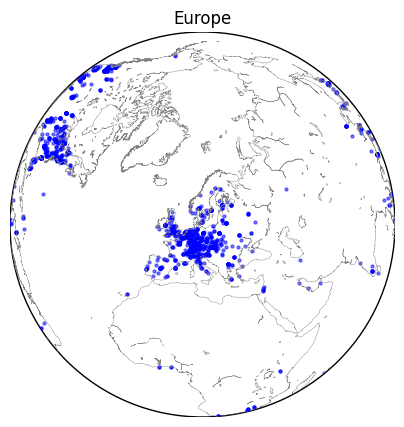

<ipython-input-29-4d6fc8b35ef8>:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  m.scatter(x, y, color='blue', s=4.5, alpha=0.5, cmap='RdBu_r')


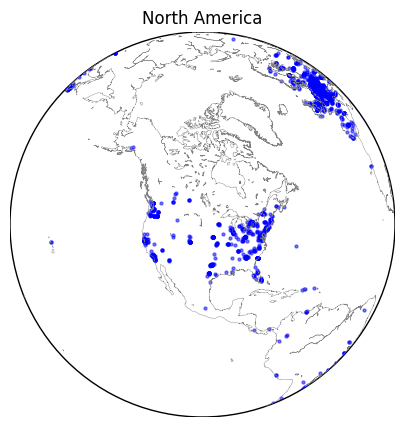

<ipython-input-29-4d6fc8b35ef8>:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  m.scatter(x, y, color='blue', s=4.5, alpha=0.5, cmap='RdBu_r')


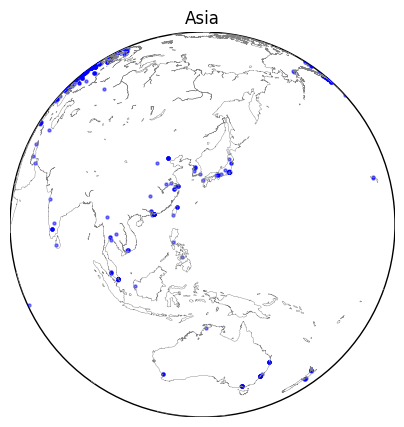

In [ ]:
plt.rcParams["figure.figsize"] = (5, 5)
m = Basemap(projection='ortho', lat_0=55, lon_0=13, resolution='l')
m.drawcoastlines(linewidth=0.3, color='gray')
#m.drawlsmask(land_color='lightgray', ocean_color='white', lakes=False)
x, y = m(nodes['longitude'], nodes['latitude'])
m.scatter(x, y, color='blue', s=4.5, alpha=0.5, cmap='RdBu_r')
plt.title("Europe")
plt.show()

m = Basemap(projection='ortho', lat_0=45, lon_0=-100, resolution='l')
m.drawcoastlines(linewidth=0.3, color='gray')
x, y = m(nodes['longitude'], nodes['latitude'])
m.scatter(x, y, color='blue', s=4.5, alpha=0.5, cmap='RdBu_r')
plt.title("North America")
plt.show()

m = Basemap(projection='ortho', lat_0=20, lon_0=130, resolution='l')
m.drawcoastlines(linewidth=0.3, color='gray')
x, y = m(nodes['longitude'], nodes['latitude'])
m.scatter(x, y, color='blue', s=4.5, alpha=0.5, cmap='RdBu_r')
plt.title("Asia")
plt.show()

LND 100.0
CLN 100.0
ECL 100.0


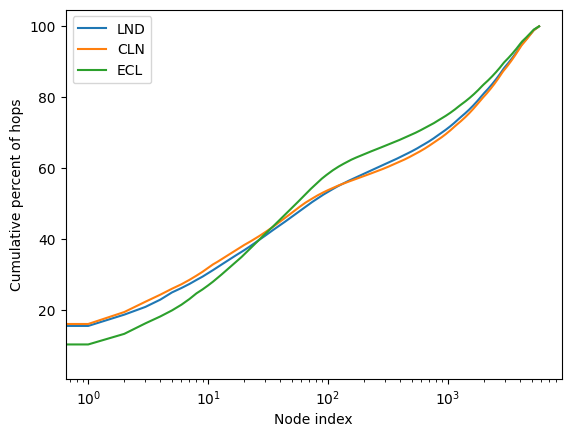

In [ ]:
for a in native_alg:
  s = pd.Series(t_nodes[a]).value_counts().reset_index(drop=True) * 100 / len(t_nodes[a])
  print(a, s.sum())
  #print(s.cumsum())
  ax = s.cumsum().plot(legend=a, label=a)
  ax.set_xlabel('Node index')
  ax.set_ylabel('Cumulative percent of hops')
  ax.set_xscale('log')

### algorithms analysis

In [ ]:
native_alg = ['LND', 'CLN', 'ECL']
modified_alg = ['H(LND)', 'H(CLN)', 'H(ECL)']
metrics = ['dist', 'geodist', 'sum_ghg', 'delay', 'feeratio'#, 'feerate',
           'intercontinental_hops', 'intercountry_hops', 'continents', 'countries',
           'avg_geodist', 'avg_ghg']
metrics_opt = ['dist', 'avg_geodist', 'avg_ghg', 'intercountry_hops', 'intercontinental_hops']
labels = {'dist':'path length',
          'avg_geodist': 'average geodistance',
          'avg_ghg' : 'average carbon intensity',
          'intercountry_hops': 'average number of intercountry hops',
          'intercontinental_hops': 'average number of intercontinental hops',
}
comparisons = [('LND', 'H(LND)'), ('CLN', 'H(CLN)'), ('ECL', 'H(ECL)')]

In [ ]:
print(e)

[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.27876, 0.25556, 0.35784]


In [ ]:
def _plot(ax, data, metrics, labels=None, title=''):
  def draw(ax, keys, labels):
      for idx, k in enumerate(keys):
        if k in data:
          sns.lineplot(ax=ax, data=data, x='e', y=k, label=labels[idx], color=_plot.palette[_plot.c], errorbar='ci')
          _plot.c += 1

  _plot.palette, _plot.c = list(mcolors.TABLEAU_COLORS.values()), 0 #list(mcolors.CSS4_COLORS.values())[45:]
  draw(ax, metrics, metrics if not labels else labels)
  ax.get_legend().remove()
  ax.set_ylabel('ε, %', fontsize=14)
  ax.set_xlabel('η', fontsize=13)
  ax.set_title(title)
  return ax.get_legend_handles_labels()

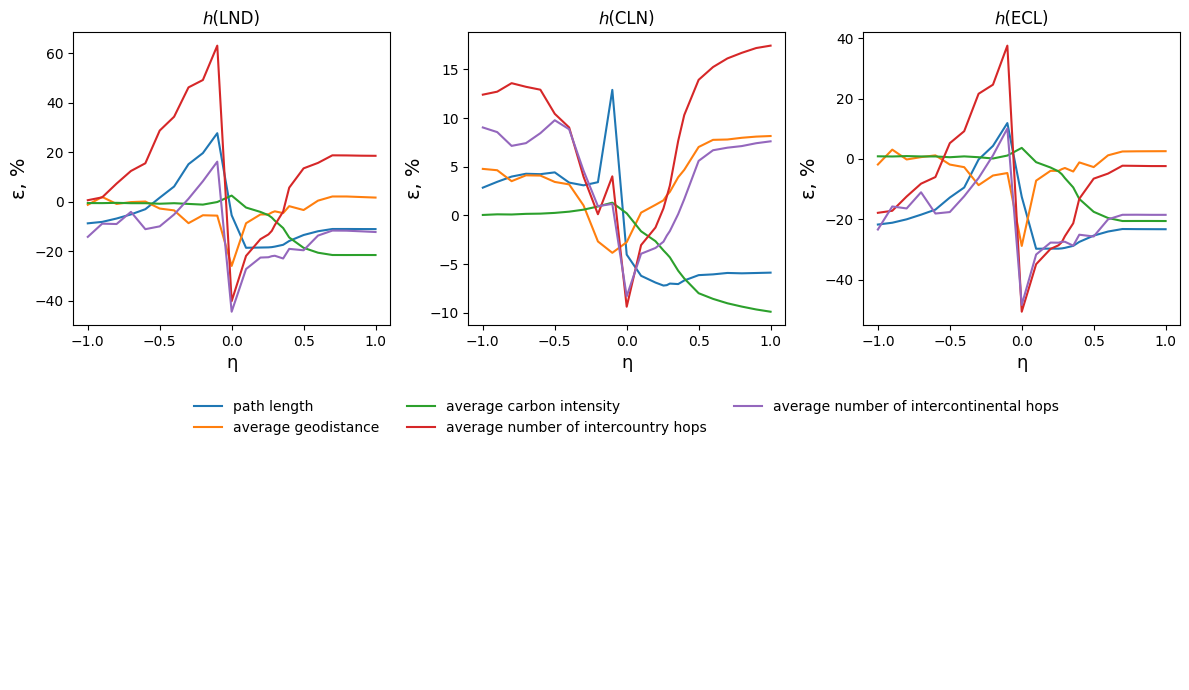

In [ ]:
fig = plt.figure(figsize=(12,7))
axs = []
for c in comparisons:
  _comparison = None
  for m in metrics_opt:
    _metric = []
    for _e in e:
      a = np.mean(metric_results[_e][m][c[0]])
      b = np.mean(metric_results[_e][m][c[1]])
      d = (b - a) * 100 / a
      _metric += [(_e, d)]
    _comparison = pd.concat([_comparison, pd.DataFrame.from_dict(_metric)\
                             .set_index([0])\
                             .rename(columns={1 : m})], axis=1)
  _comparison = _comparison.reset_index().rename(columns={0 : 'e'})
  _labels = [labels[m] for m in metrics_opt]
  axs += [fig.add_subplot(230+len(axs)+1)]
  h, l = _plot(axs[-1], _comparison, metrics_opt, _labels, f"ℎ({c[0]})")

ax = fig.add_subplot(212)
ax.set_axis_off()
ax.legend(loc='upper center', handles=h, labels=l, ncol=3).get_frame().set_linewidth(0.0)
fig.tight_layout()
plt.show()

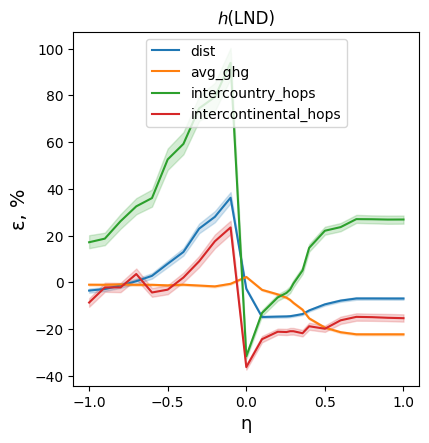

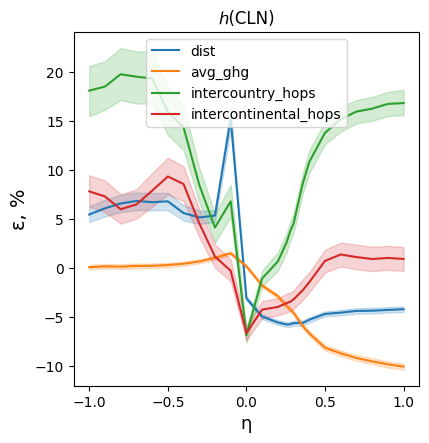

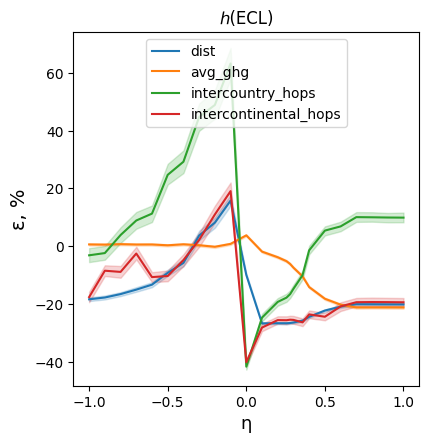

In [ ]:
for c in comparisons:
  _comparison = None
  for m in metrics_opt:
    if m != 'avg_geodist':
      _metric = []
      for _e in e:
        a = np.array(metric_results[_e][m][c[0]])
        b = np.array(metric_results[_e][m][c[1]])
        d = (b - a) * 100 / a
        _metric += [(_e, i) for i in d]
      _comparison = pd.concat([_comparison, pd.DataFrame.from_dict(_metric)\
                              .set_index([0])\
                              .rename(columns={1 : m})], axis=1)
  _comparison = _comparison.reset_index().rename(columns={0 : 'e'})
  _plot(_comparison, metrics_opt, f"ℎ({c[0]})")

In [ ]:
comparison = [('dist', 'intercontinental_hops'),
              ('dist', 'intercountry_hops'),
              ('dist', 'geodist'),
              ('dist', 'avg_geodist'),
              ('dist', 'avg_ghg'),
              ('dist', 'sum_ghg'),
              ('avg_geodist', 'intercontinental_hops'),
              ('avg_geodist', 'intercountry_hops'),
              ('avg_geodist', 'avg_ghg'),
              ('avg_geodist', 'sum_ghg'),
              ]

results = metric_results[e[0]]
print('---all---')
for a in native_alg:
  for c in comparison:
    r = spearmanr(results[c[0]][a], results[c[1]][a])
    print(f"{a}, {c[0]}, {c[1]:<22}: {r[0]:.2f}, {r[1]:.4f}{get_stars(r[1])}")

print('---same continent---')
for a in native_alg:
  for c in comparison:
    _a, _b = results[c[0]][a], results[c[1]][a]
    _a = [i for idx, i in enumerate(_a) if len(results['continents'][a][idx]) and results['continents'][a][idx][0] == results['continents'][a][idx][-1]]
    _b = [i for idx, i in enumerate(_b) if len(results['continents'][a][idx]) and results['continents'][a][idx][0] == results['continents'][a][idx][-1]]
    r = spearmanr(_a, _b)
    print(f"{a}, {c[0]}, {c[1]:<22}: {r[0]:.2f}, {r[1]:.4f}{get_stars(r[1])}")

---all---
LND, dist, intercontinental_hops : 0.37, 0.0000***
LND, dist, intercountry_hops     : 0.41, 0.0000***
LND, dist, geodist               : 0.44, 0.0000***
LND, dist, avg_geodist           : 0.12, 0.0000***
LND, dist, avg_ghg               : 0.05, 0.0000***
LND, dist, sum_ghg               : 0.86, 0.0000***
LND, avg_geodist, intercontinental_hops : 0.86, 0.0000***
LND, avg_geodist, intercountry_hops     : 0.74, 0.0000***
LND, avg_geodist, avg_ghg               : -0.32, 0.0000***
LND, avg_geodist, sum_ghg               : -0.03, 0.0109*
CLN, dist, intercontinental_hops : 0.13, 0.0000***
CLN, dist, intercountry_hops     : 0.20, 0.0000***
CLN, dist, geodist               : 0.21, 0.0000***
CLN, dist, avg_geodist           : -0.05, 0.0000***
CLN, dist, avg_ghg               : 0.14, 0.0000***
CLN, dist, sum_ghg               : 0.88, 0.0000***
CLN, avg_geodist, intercontinental_hops : 0.88, 0.0000***
CLN, avg_geodist, intercountry_hops     : 0.72, 0.0000***
CLN, avg_geodist, avg_ghg    

In [ ]:
comparison = [('LND', 'H(LND)'), ('CLN', 'H(CLN)'), ('ECL', 'H(ECL)')]
for c, _e in zip(comparison, [0.27876, 0.25556, 0.35784]):
  print(f'---all--- e={_e}')
  results = metric_results[_e]
  for m in metrics_opt + ['delay', 'feeratio']:
    if m in results and c[0] in results[m] and c[1] in results[m] and len(results[m][c[1]]):
        print_stat(m, c[1], results[m][c[1]], c[0], results[m][c[0]])

---all--- e=0.27876
dist:   H(LND) 4.342(10000) <> LND 5.322(10000), ε=-18.4%, U=27722517.0, p=0.000***
avg_geodist: H(LND) 1949.118(10000) <> LND 2038.746(10000), ε=-4.4%, U=46992556.0, p=0.000***
avg_ghg: H(LND) 322.157(10000) <> LND 344.315(10000), ε=-6.4%, U=47724744.0, p=0.000***
intercountry_hops: H(LND) 1.438(10000) <> LND 1.631(10000), ε=-11.9%, U=46036852.0, p=0.000***
intercontinental_hops: H(LND) 1.013(10000) <> LND 1.300(10000), ε=-22.1%, U=42552727.5, p=0.000***
delay:  H(LND) 211.809(10000) <> LND 192.870(10000), ε=+9.8%, U=54452078.0, p=0.000***
feeratio: H(LND) 1.076(10000) <> LND 1.072(10000), ε=+0.4%, U=58497560.5, p=0.000***
---all--- e=0.25556
dist:   H(CLN) 4.634(10000) <> CLN 4.994(10000), ε=-7.2%, U=41154377.5, p=0.000***
avg_geodist: H(CLN) 1845.642(10000) <> CLN 1817.501(10000), ε=+1.5%, U=50697118.5, p=0.088
avg_ghg: H(CLN) 340.216(10000) <> CLN 352.922(10000), ε=-3.6%, U=45704916.5, p=0.000***
intercountry_hops: H(CLN) 1.350(10000) <> CLN 1.340(10000), ε=+0.7